In [1]:
''' Import packages/modules. '''

import sys
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
import pywt
import numpy as np
import math
from copy import deepcopy
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal
import scipy.interpolate as sint

sys.path.insert(0, '/home/elott1/code')

from ColorDataUtils.DDPIutils import DDPIutils
from NDNT.utils import DanUtils as DU

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
''' Load data into seperate trials. '''

datadir = '/home/dbutts/ColorV1/Data/'
f = 'Jocamo0331_dpi_calibrated'

data = DDPIutils(filename=f, data_dir=datadir)

Seperating trials...
Done.


In [4]:
''' Process all trials and view distributions of saccade stats. Takes about 1 min. per 200 trials. '''

for i in range(data.num_trials):
    data.process_trial(tr=i, verbose=False)
    data.process_fixations(tr=i)

#data.saccade_stats()

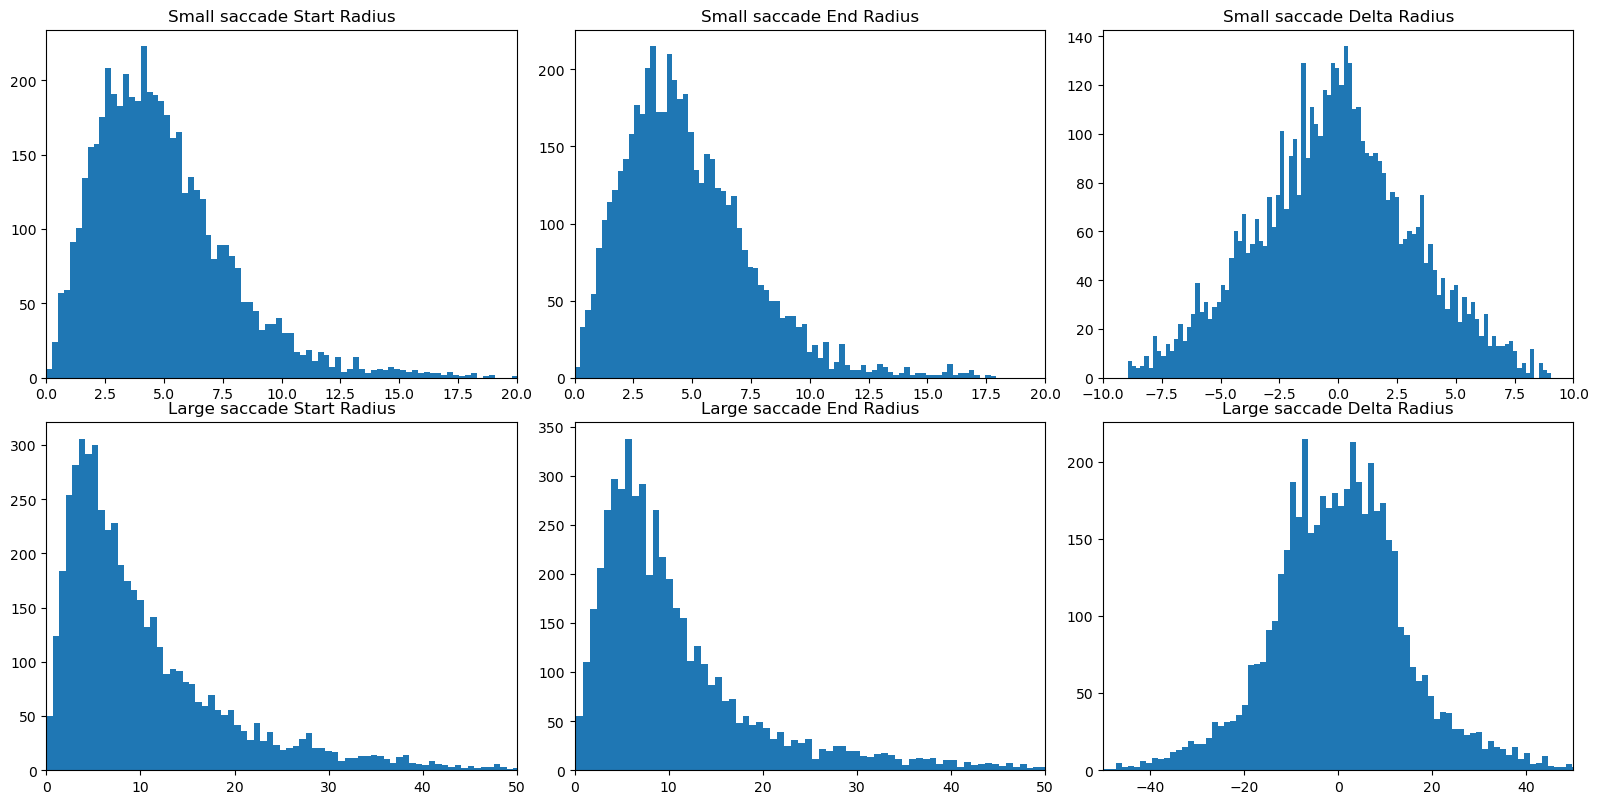

In [5]:
''' Check for patterns in saccade behavior. '''

dr = np.zeros([0,1])
start = np.zeros(0)
end = np.zeros(0)
for i, rad in enumerate(data.sacc_rads):
    if data.num_sacc[i] > 0:
        start = np.concatenate([start, rad[:,0]])
        end = np.concatenate([end, rad[:,1]])
        dr = np.concatenate([dr, np.diff(rad, axis=1)])
dr = dr.squeeze()
start = start.squeeze()
end = end.squeeze()

all_saccs = np.zeros(0)
for saccs in data.sacc_sizes:
    all_saccs = np.concatenate([all_saccs, saccs])

med_size = np.median(all_saccs)
small_sacc = np.where(all_saccs < med_size)[0]
big_sacc = np.where(all_saccs > med_size)[0]

DU.ss(2,3,rh=4)
plt.subplot(231)
plt.title('Small saccade Start Radius')
plt.xlim(0,20)
plt.hist(start[small_sacc], bins=100)
# plt.axvline(x=start[small_sacc].mean(), color='green', linestyle='dashed')
plt.subplot(232)
plt.title('Small saccade End Radius')
plt.xlim(0,20)
plt.hist(end[small_sacc], bins=100)
# plt.axvline(x=end[small_sacc].mean(), color='green', linestyle='dashed')
plt.subplot(233)
plt.title('Small saccade Delta Radius')
plt.xlim(-10,10)
plt.hist(dr[small_sacc], bins=100)
# plt.axvline(x=dr[small_sacc].mean(), color='green', linestyle='dashed')
plt.subplot(234)
plt.title('Large saccade Start Radius')
plt.xlim(0,50)
plt.hist(start[big_sacc], bins=120)
# plt.axvline(x=start[big_sacc].mean(), color='green', linestyle='dashed')
plt.subplot(235)
plt.title('Large saccade End Radius')
plt.xlim(0,50)
plt.hist(end[big_sacc], bins=120)
# plt.axvline(x=end[big_sacc].mean(), color='green', linestyle='dashed')
plt.subplot(236)
plt.title('Large saccade Delta Radius')
plt.xlim(-50,50)
plt.hist(dr[big_sacc], bins=120)
# plt.axvline(x=dr[big_sacc].mean(), color='green', linestyle='dashed')
plt.show()

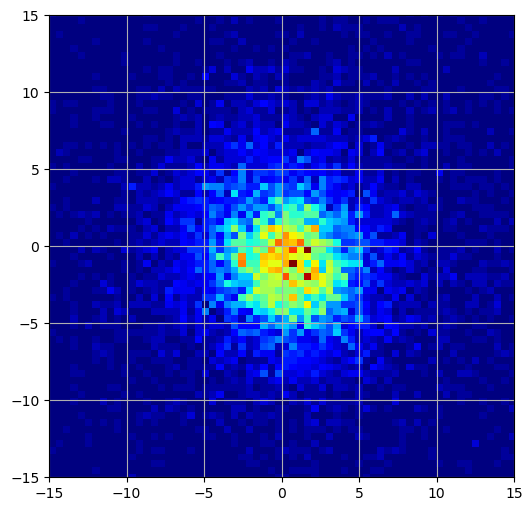

In [6]:
''' Fixation position density. '''

total_fixes = data.num_sacc.sum() + data.num_trials

avg_fix_point = np.zeros([total_fixes, 2])
i = 0

for fixes in data.fix_avg_et:
    for fix in fixes:
        avg_fix_point[i] = fix[:,1:].mean(axis=0) if fix.shape[0] > 0 else 0
        i += 1

avg_fix_point = np.delete(avg_fix_point, np.unique(np.where(avg_fix_point==0)), axis=0)

avgs = avg_fix_point.mean(axis=0)
plt.figure(figsize=(6,6))
plt.hist2d(avg_fix_point[:,0], avg_fix_point[:,1], bins=(300,300), cmap=plt.cm.jet)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.grid()

plt.show()

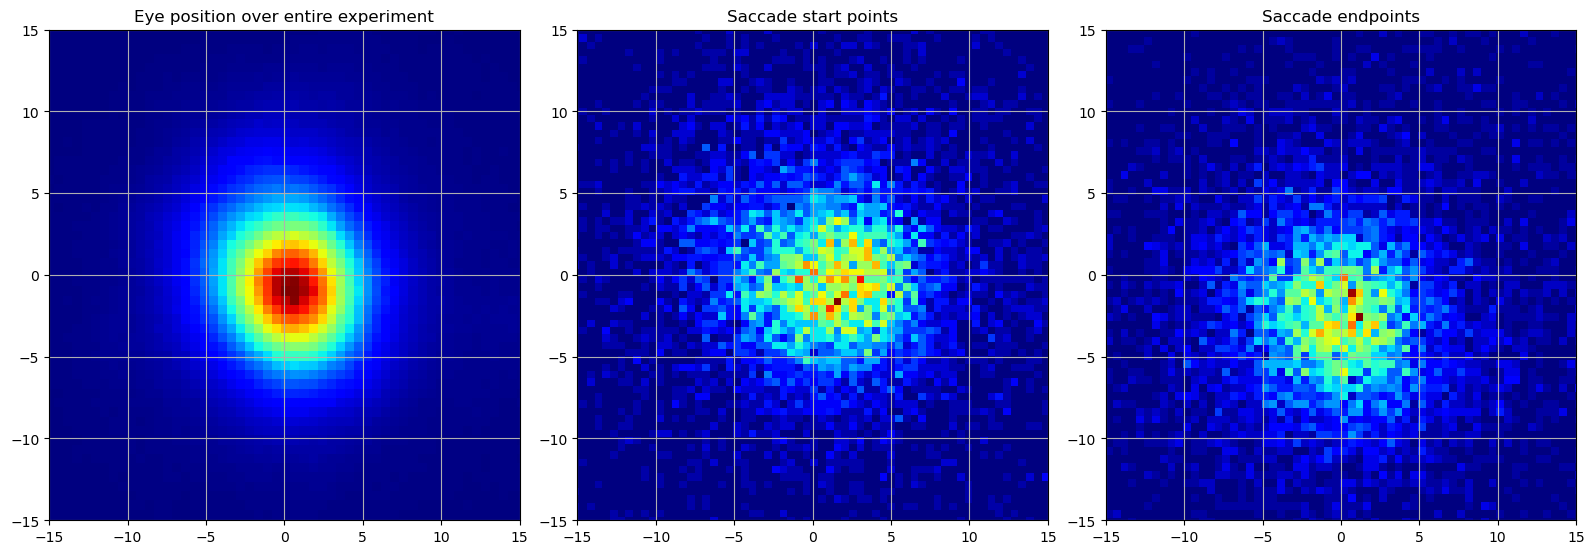

In [7]:
''' Eye position density at saccade points. '''

full_et = np.zeros([0,3])
for et in data.trial_et:
    full_et = np.concatenate([full_et, et])
full_et = np.delete(full_et, np.unique(np.where(full_et==0)), axis=0)

full_start = np.zeros([0,2])
full_end = np.zeros([0,2])
for t, dts in enumerate(data.sacc_dt):
    for dt in dts:
        full_start = np.concatenate([full_start, data.trial_et[t][int(dt[0]),1:].reshape(1,2)])
        full_end = np.concatenate([full_end, data.trial_et[t][int(dt[1])-1,1:].reshape(1,2)])

DU.ss(1,3,rh=5.5)
plt.subplot(131)
plt.hist2d(full_et[:,1], full_et[:,2], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Eye position over entire experiment')
plt.subplot(132)
plt.hist2d(full_start[:,0], full_start[:,1], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Saccade start points')
plt.subplot(133)
plt.hist2d(full_end[:,0], full_end[:,1], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Saccade endpoints')
plt.show()

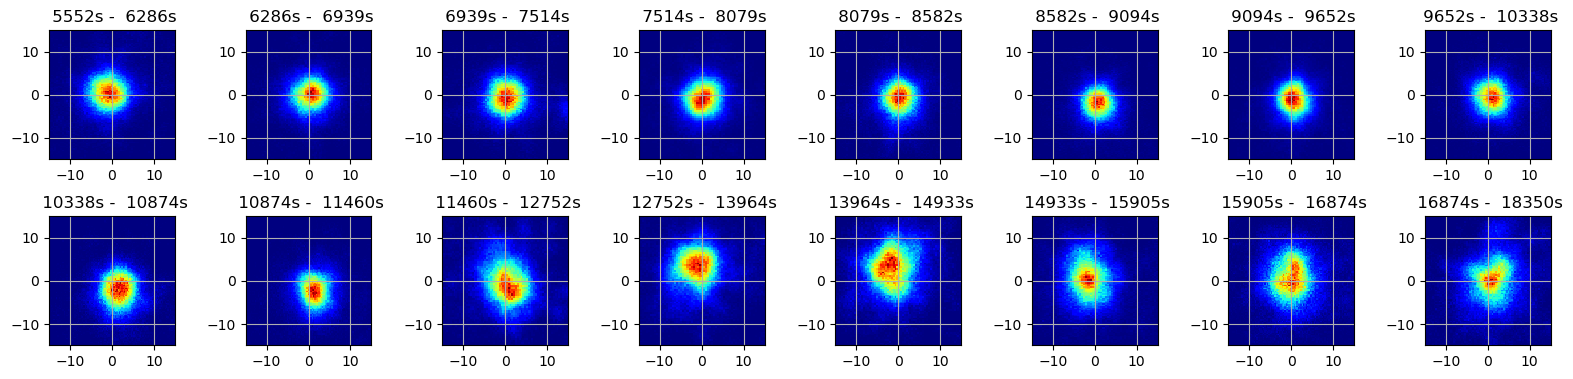

In [8]:
''' Eye positon density over time. '''

num_chunk = 16
chunk = full_et.shape[0]//num_chunk
c = 8
r = math.ceil(num_chunk/c)

DU.ss(r,c,rh=2)
plt.tight_layout(pad=2)
for i in range(num_chunk):
    plt.subplot(r,c,i+1)
    plt.title(f'{full_et[chunk*i,0]: .0f}s - {full_et[chunk*(i+1),0]: .0f}s')
    plt.hist2d(full_et[chunk*i:chunk*(i+1),1], full_et[chunk*i:chunk*(i+1),2], bins=(300, 300), cmap=plt.cm.jet)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.grid()
plt.show()

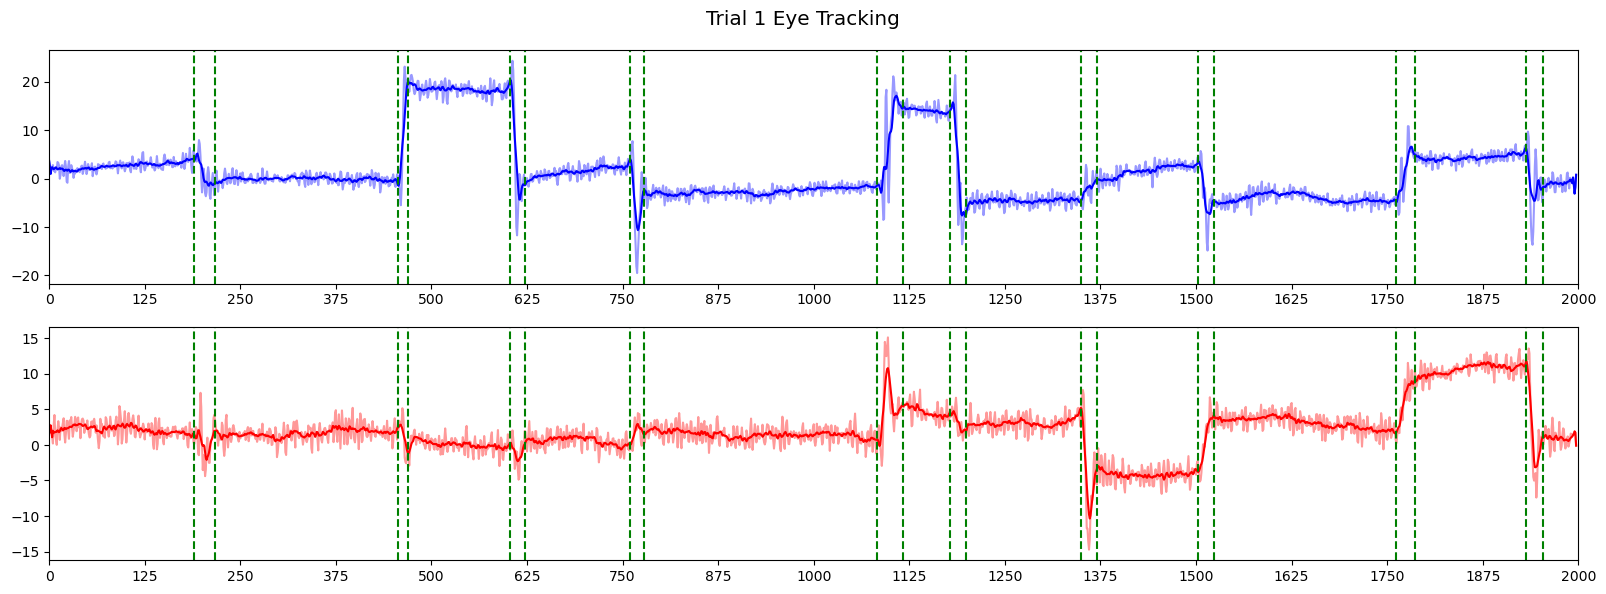

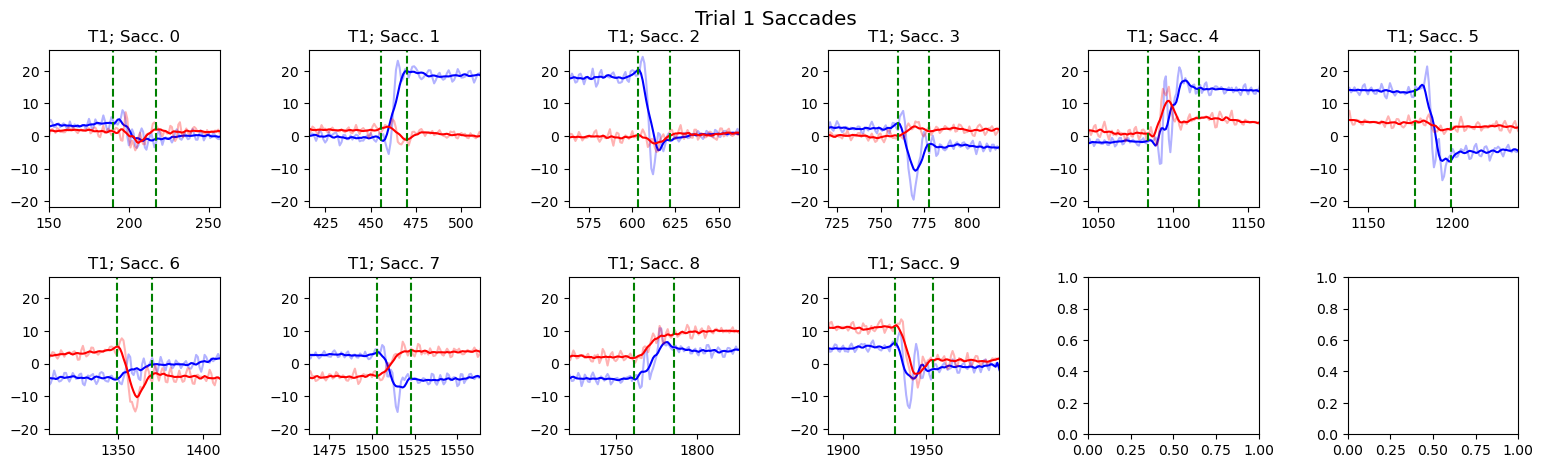

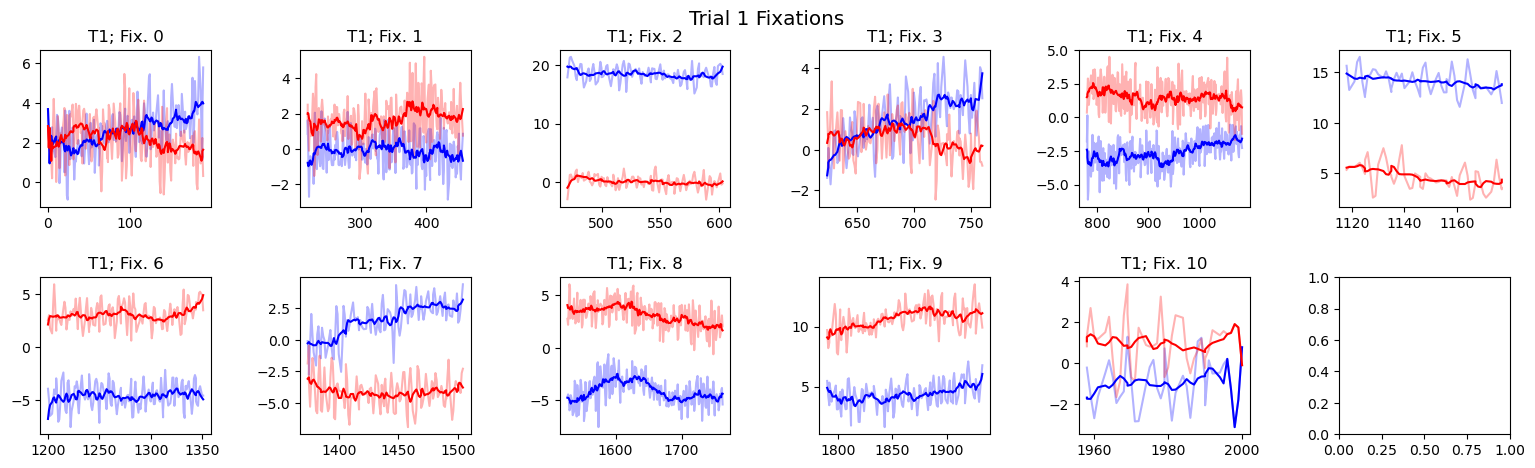

In [8]:
''' Process and plot a single trial. '''

tr = 1

if (data.processed[tr,0] == 0):
    data.process_trial(tr)
if (data.processed[tr,1] == 0):
    data.process_fixations(tr)
    
data.plot_trial(tr)
data.plot_saccades(tr, c=6, rh=2.5)
data.plot_fixations(tr, c=6, rh=2.5)

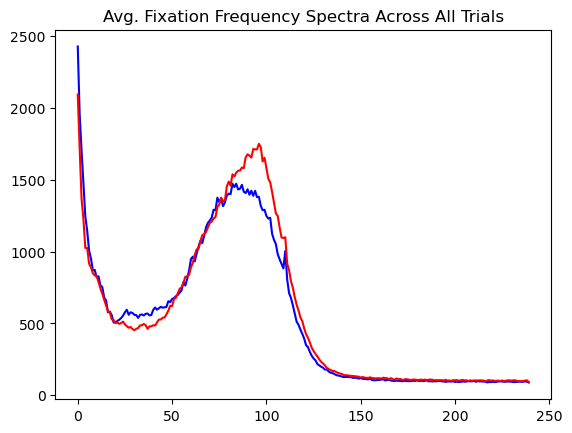

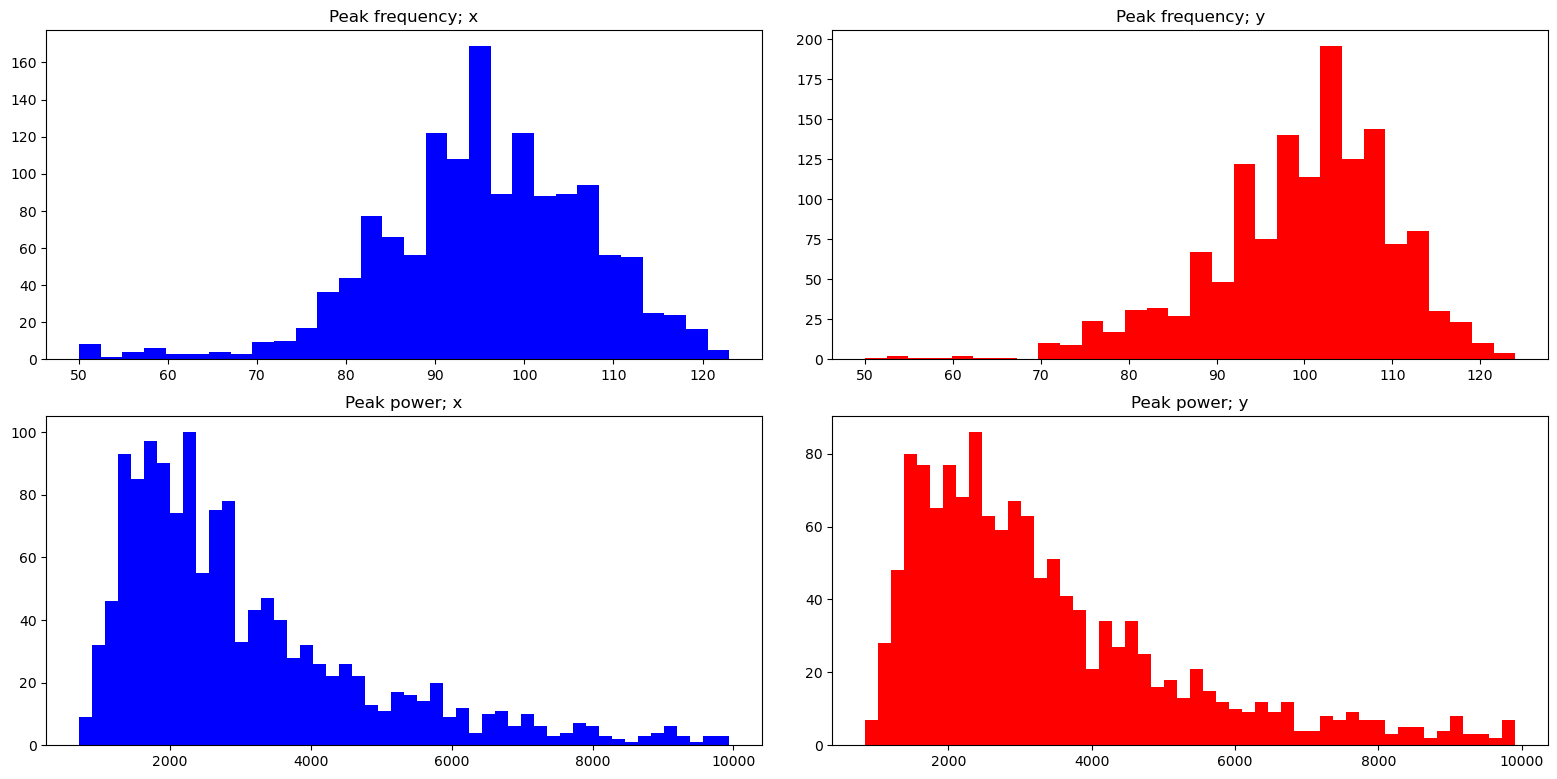

In [9]:
''' Calculate and plot average frequency spectra for entire experiment. '''

data.fft_fixations(to_plot=2)

In [138]:
''' Apply low-pass filter (hard cutoff) to each fixation of every trial. '''

st_avg, end_avg = data.LPfilt_trials()

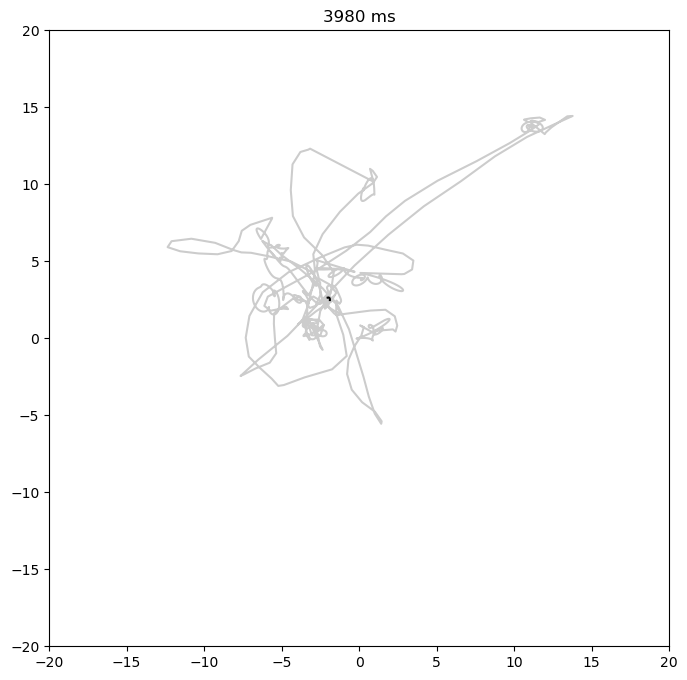

In [15]:
''' Plot and save GIFs of a trial. Takes about 4 min. for a full trial. '''

data.generate_gif(tr=10)
data.generate_gif(tr=10, filtered=True, trail=8)

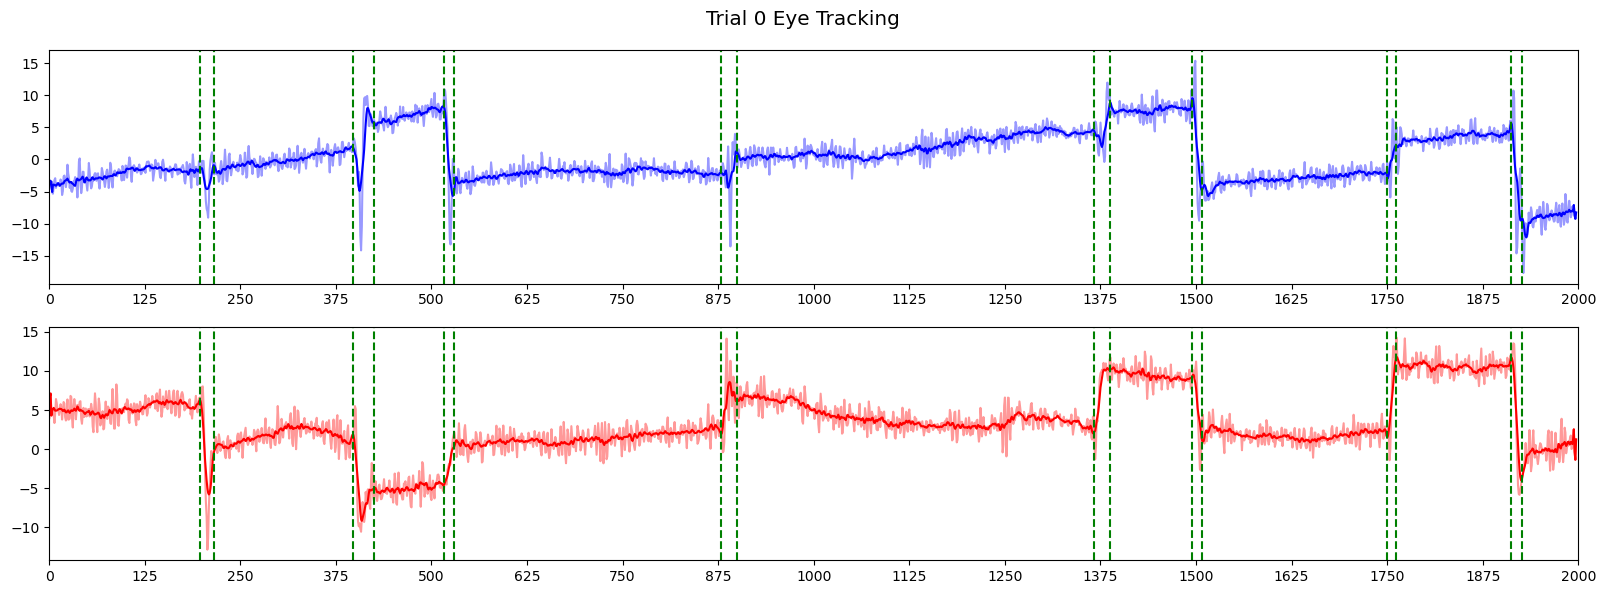

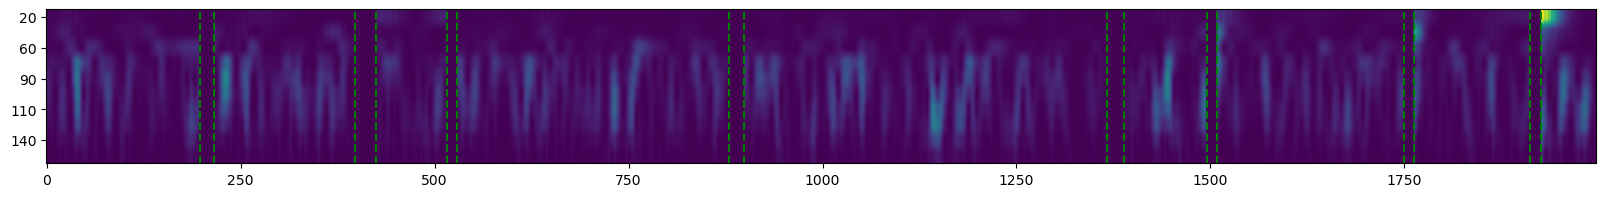

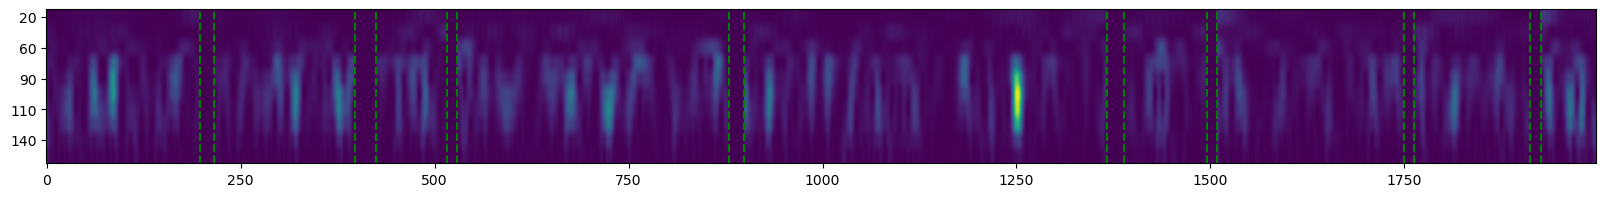

In [24]:
''' Perform and plot wavelet decompositions of a single trial. '''

tr = 0
new_pow_x, new_pow_y = [], []
freqs = np.array([20, 40, 60, 80, 90, 100, 110, 120, 140, 160])
scale = pywt.frequency2scale('cmor1.5-1.0', freqs * data.dt)

for i, fix in enumerate(data.fix_et[tr]):
    fix_x = fix[:,1]
    fix_y = fix[:,2]

    t = fix.shape[0]
    fix_xr = np.flip(fix_x)
    fix_yr = np.flip(fix_y)
    fix_x = np.concatenate([fix_xr, fix_x, fix_xr])
    fix_y = np.concatenate([fix_yr, fix_y, fix_yr])

    wav = pywt.ContinuousWavelet('cmor1.5-1.0')

    out_x = pywt.cwt(fix_x , scale, wav)[0][:,t:2*t]
    out_y = pywt.cwt(fix_y , scale, wav)[0][:,t:2*t]

    wavelet_out_x = np.abs(out_x)
    wavelet_out_y = np.abs(out_y)
    new_pow_x.append(wavelet_out_x**2)
    new_pow_y.append(wavelet_out_y**2)

full_fix_wavelet = np.zeros([data.trial_et[tr].shape[0],10,2])
last1 = 0

for i, sacc in enumerate(data.sacc_dt[tr]): 
    full_fix_wavelet[last1:int(sacc[0]),:,0] = new_pow_x[i].T
    full_fix_wavelet[last1:int(sacc[0]),:,1] = new_pow_y[i].T
    last1 = int(sacc[1])+1

full_fix_wavelet[last1:,:,0] = new_pow_x[i+1].T
full_fix_wavelet[last1:,:,1] = new_pow_y[i+1].T

# Plot decompositions
data.plot_trial(tr)

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_fix_wavelet[:,:,0].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_fix_wavelet[:,:,1].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

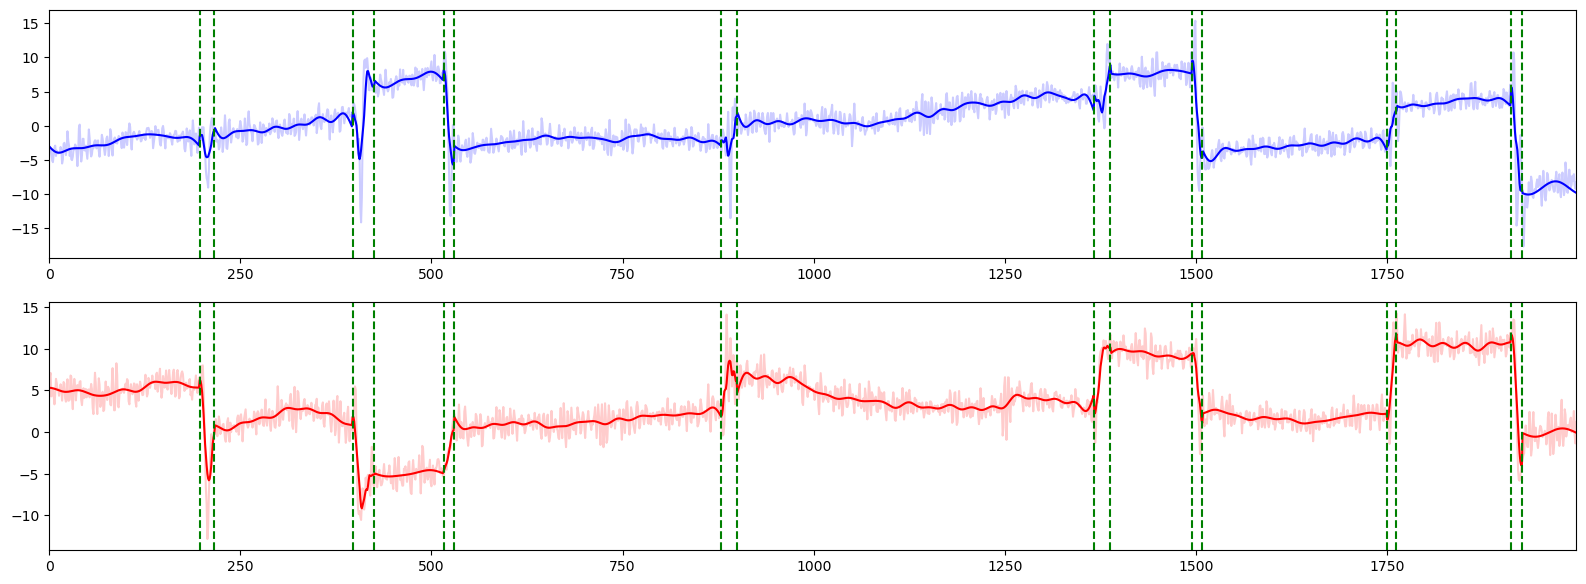

In [28]:
''' Plot single filtered trial. '''

tr = 0
DU.ss(2,1,rh=3)

plt.subplot(211)
plt.margins(x=0)
plt.plot(full_filt[tr][:,1], color='blue')
plt.plot(data.trial_et[tr][:,1], alpha=0.2, color='blue')
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
    
plt.subplot(212)
plt.margins(x=0)
plt.plot(full_filt[tr][:,2], color='red')
plt.plot(data.trial_et[tr][:,2], alpha=0.2, color='red')
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

In [117]:
''' Calculate ocular drift stats. '''

all_arcs = []
all_arcs0 = np.zeros(0)
for trial in range(data.num_trials):

    filt_fix = []

    for dt in data.fix_dt[trial]:
        if dt[1] > dt[0]:
            filt_fix.append(data.filt_et[trial][int(dt[0]):int(dt[1])-1])
    arc = np.zeros(len(filt_fix))

    for i, fix in enumerate(filt_fix):
        for t in range(fix.shape[0]-1):
            arc[i] += ((fix[t+1,1] - fix[t,1])**2 + (fix[t+1,2] - fix[t,2])**2)**0.5
    all_arcs.append(arc)
    all_arcs0 = np.concatenate([all_arcs0, arc])

all_disp = []
all_dx = []
all_dy = []
for trial in range(data.num_trials):

    for i in range(len(st_avg[trial])):
        disp = ((end_avg[trial][i][0] - st_avg[trial][i][0])**2 + (end_avg[trial][i][1] - st_avg[trial][i][1])**2)**0.5
        all_disp.append(disp)
        all_dx.append(end_avg[trial][i][0] - st_avg[trial][i][0])
        all_dy.append(end_avg[trial][i][1] - st_avg[trial][i][1])
all_disp = np.array(all_disp)
all_dx = np.array(all_dx)
all_dy = np.array(all_dy)


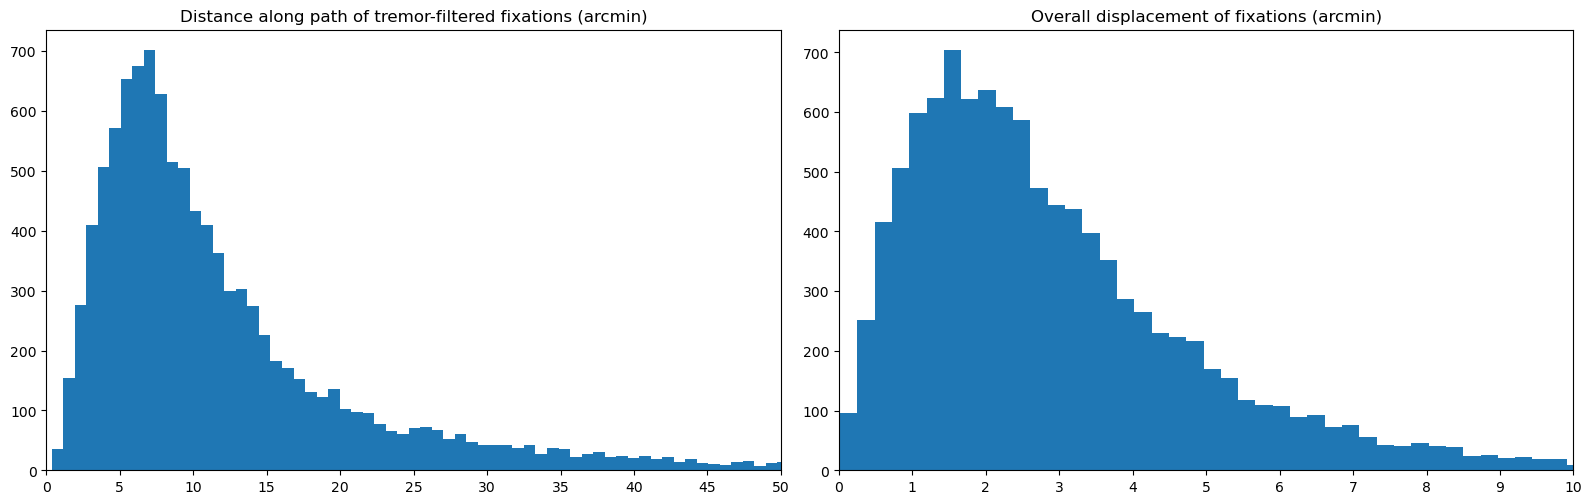

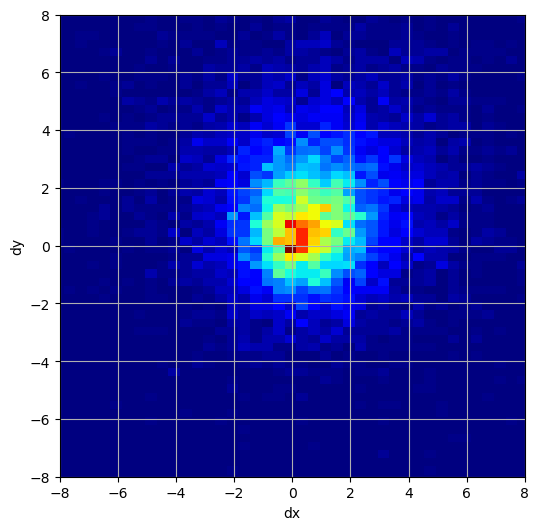

In [118]:
''' Plot ocular drift stats. '''

DU.ss(1,2,rh=5)
ind = np.where(all_arcs0 == 0)


all_arcs0 = np.delete(all_arcs0, ind)
plt.subplot(121)
plt.hist(all_arcs0, bins=500)
plt.xticks(range(0,51,5))
plt.xlim(0,50)
plt.title('Distance along path of tremor-filtered fixations (arcmin)')


all_disp = np.delete(all_disp, ind)
plt.subplot(122)
plt.hist(all_disp, bins=400)
plt.xticks(range(11))
plt.xlim(0,10)
plt.title('Overall displacement of fixations (arcmin)')
plt.show()

# DU.ss(1,2,rh=5)
# plt.subplot(1,2,1)
# plt.hist(all_dx, bins=400, color='blue')
# plt.xticks(range(-10,11))
# plt.xlim(-10,10)
# plt.title('dx')

# plt.subplot(1,2,2)
# plt.hist(all_dy, bins=400, color='red')
# plt.xticks(range(-10,11))
# plt.xlim(-10,10)
# plt.title('dy')
# plt.show()

plt.figure(figsize=(6,6))
plt.hist2d(all_dx, all_dy, bins=(400,400), cmap=plt.cm.jet)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.grid()
plt.xlabel('dx')
plt.ylabel('dy')
plt.show()

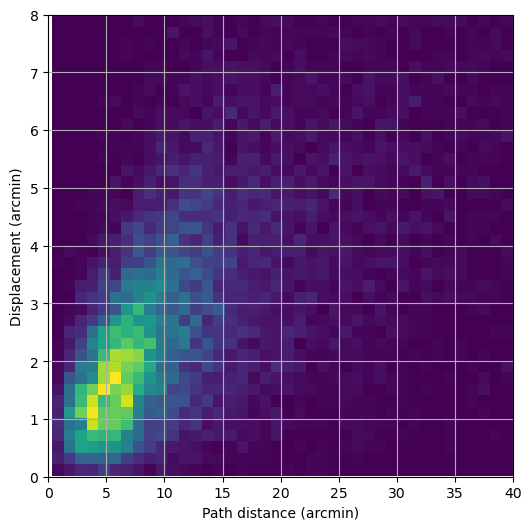

In [79]:
''' Relationship between path length and displacement of ocular drift. '''

inds = np.unique(np.concatenate([np.where(all_arcs0 > 40)[0], np.where(all_disp > 8)[0]]))
all_arcs0 = np.delete(all_arcs0, inds)
all_disp = np.delete(all_disp, inds)

plt.figure(figsize=(6,6))
plt.hist2d(all_arcs0, all_disp, bins=(40,40), cmap='viridis')
plt.xlim(0,40)
plt.ylim(0,8)
plt.grid()
plt.xlabel('Path distance (arcmin)')
plt.ylabel('Displacement (arcmin)')
plt.show()

In [137]:
sacc_x = np.zeros(0)
sacc_y = np.zeros(0)

for tr in range(data.num_trials):
    x = data.sacc_xy[tr][:,0].reshape(-1)
    y = data.sacc_xy[tr][:,1].reshape(-1)
    sacc_x = np.concatenate([sacc_x, x])
    sacc_y = np.concatenate([sacc_y, y])

In [139]:
idx = np.unique(np.concatenate((np.where(np.abs(sacc_x) > 20)[0], np.where(np.abs(sacc_y) > 20)[0])))
sacc_x = np.delete(sacc_x, idx)
sacc_y = np.delete(sacc_y, idx)

idx_drift = np.unique(np.concatenate((np.where(np.abs(all_dx) > 20)[0], np.where(np.abs(all_dy) > 20)[0])))
all_dx = np.delete(all_dx, idx_drift)
all_dy = np.delete(all_dy, idx_drift)

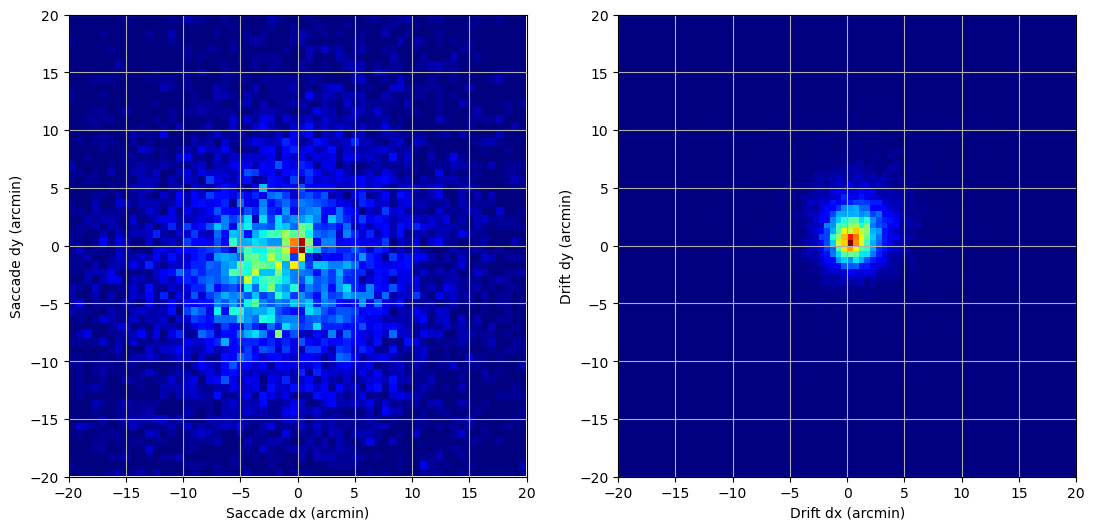

In [146]:
plt.subplots(1,2,figsize=(13,6))

plt.subplot(121)
plt.hist2d(sacc_x, sacc_y, bins=(60,60), cmap='jet')
plt.grid()
plt.xlabel('Saccade dx (arcmin)')
plt.ylabel('Saccade dy (arcmin)')
plt.xlim(-20,20)
plt.ylim(-20,20)

plt.subplot(122)
plt.hist2d(all_dx, all_dy, bins=(np.arange(-20,21,0.5),np.arange(-20,21,0.5)), cmap=plt.cm.jet)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.grid()
plt.xlabel('Drift dx (arcmin)')
plt.ylabel('Drift dy (arcmin)')
plt.show()

In [158]:
print(f'Mean saccade: ({sacc_x.mean(): 0.2f}, {sacc_y.mean(): 0.2f})')
print(f'Mean drift: ({all_dx.mean(): 0.2f}, {all_dy.mean(): 0.2f})')S

Mean saccade: (-0.86, -1.88)
Mean drift: ( 0.68,  1.30)
